# Making PID again

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

Tracking for periodic orbit:

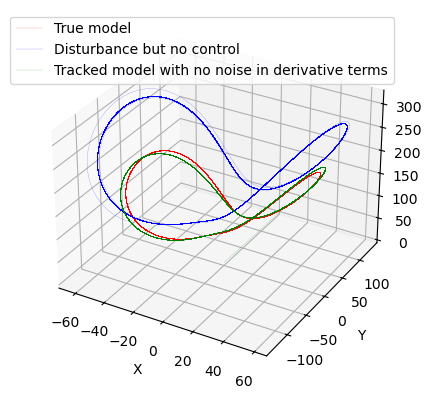

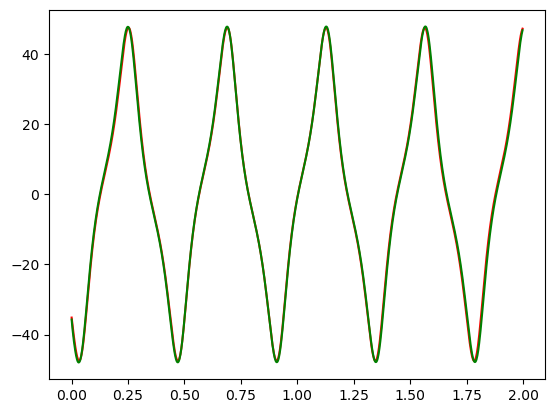

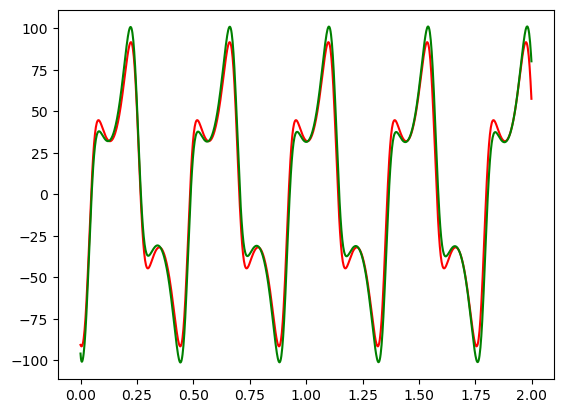

In [3]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 70
controlgain = 0.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xtrack - xxpid)
    yypid += dt * yypidp + controlgain * (ytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (ztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with no noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

For disturbance factor of 70, starting to show deviation

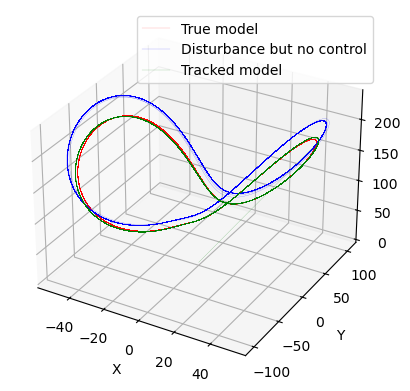

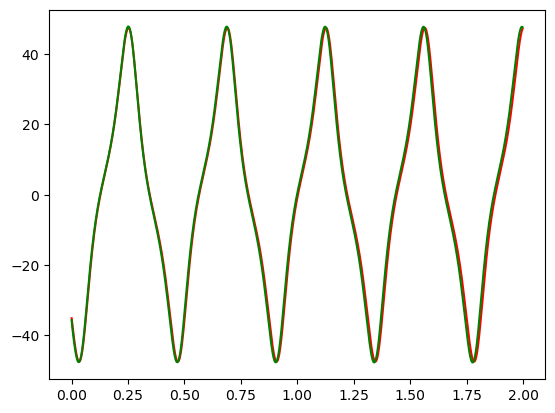

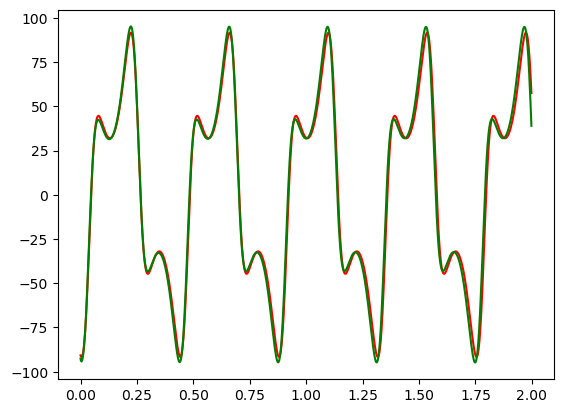

In [3]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
#A = sp.csr_matrix(A1)
A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 20
controlgain = 0.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xtrack - xxpid)
    yypid += dt * yypidp + controlgain * (ytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (ztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

Without A

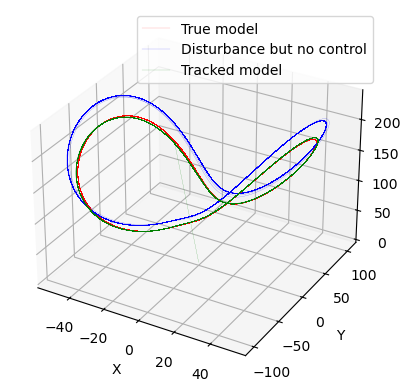

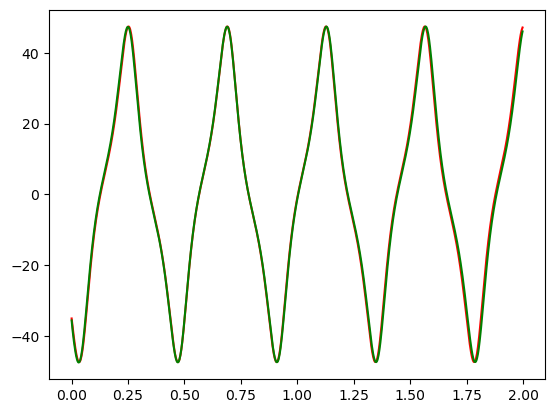

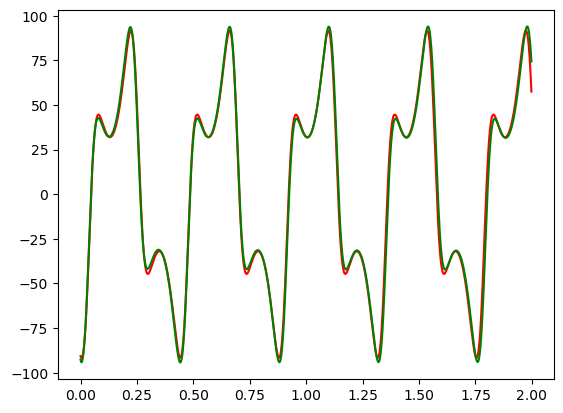

In [5]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
#A = sp.csr_matrix(A1)
A = np.zeros((n, n))

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 20
controlgain = 0.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xtrack - xxpid)
    yypid += dt * yypidp + controlgain * (ytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (ztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

Works perfectly without the integral term. Need to test for other disturbance terms. And maybe on rossler system. In chaotic orbit:

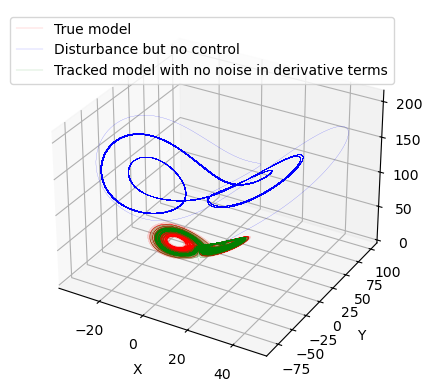

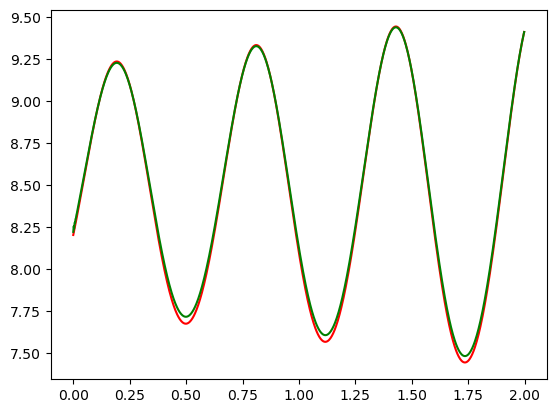

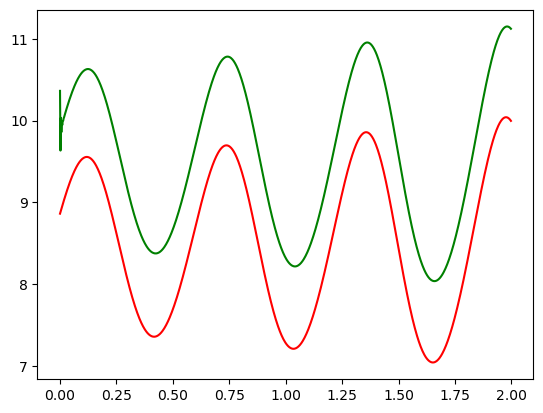

In [21]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 90
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xtrack - xxpid)
    yypid += dt * yypidp + controlgain * (ytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (ztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with no noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

Works decently for chaotic regime as well.

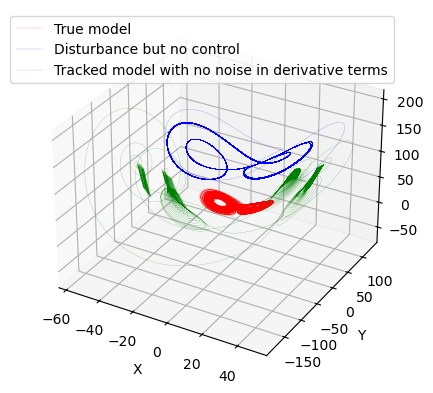

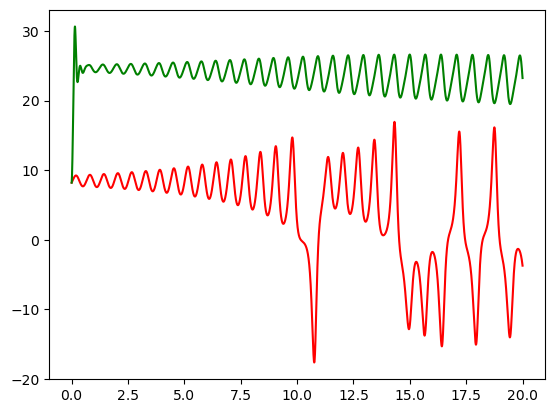

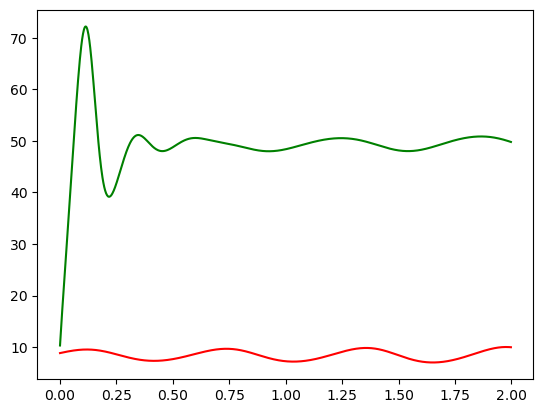

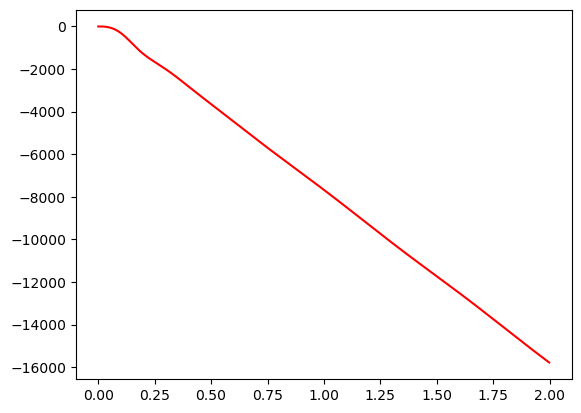

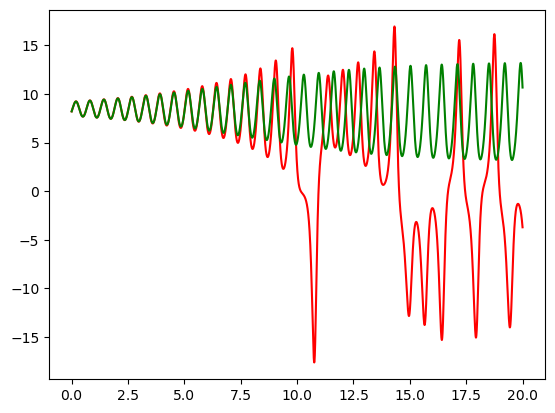

In [29]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 10
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
f = f[:, -10000:] 
R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 90
Kp = 15
Ki = 0.0005

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
err = np.zeros((3, ntest))
cumulerr = np.zeros((3, ntest + 1))

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

xxtrack = np.zeros(ntest)
yytrack = np.zeros(ntest)
zztrack = np.zeros(ntest)

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxtrack[t] = xtrack
    yytrack[t] = ytrack
    zztrack[t] = ztrack


    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    err = np.array([xtrack, ytrack, ztrack]) - np.array([xxpid, yypid, zzpid])
    cumulerr[:, t + 1] = cumulerr[:, t] + err
    xxpid += dt * (xxpidp + Kp * (xtrack - xxpid) + Ki * cumulerr[0, t])
    yypid += dt * (yypidp + Kp * (ytrack - yypid) + Ki * cumulerr[1, t])
    zzpid += dt * (zzpidp + Kp * (ztrack - zzpid) + Ki * cumulerr[2, t])
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with no noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:10000], xpure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], xpid[:10000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[:1000], cumulerr[0, :1000], 'r', label = 'True model')
#plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()

plt.figure()
plt.plot(testingtimes[:10000], xpure[:10000], 'r', label = 'True model')
plt.plot(testingtimes[:10000], xxtrack[:10000],  'g', label = 'Tracked model')
plt.show()


Removing the A matrix has reduced the complexity by a lot, making the code run way faster. It also potentially makes it easier to understand. Say the time series data matrix is 3 x 10000. By transforming and storing it in a parametrized form, we have a Win matrix generated randomly with size 3 x 1000 and the tanh dynamics of the reservoir is storing the data instead of the actual time series data. We essentially have a 1000 x 10000 matrix of reservoir time series data, which is just the same information being stored in a higher dimension space, kinda like attention blocks in transformers - the query, key matrices thing where 128 dimension is taken to something higher. This is again transformed down back to however many dimensions we want. The novelty here is, we can fit it into whatever data we want by using ridge-regression. In other words, instead of backprop, we use a direct minimization to find the final weights.

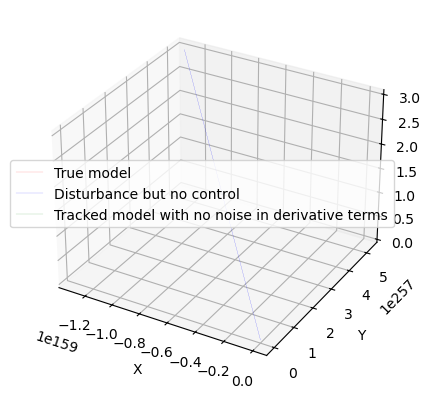

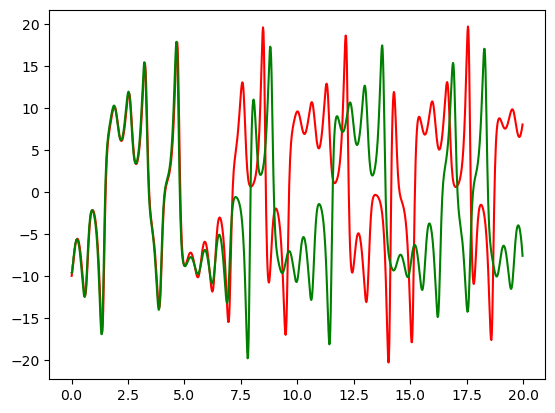

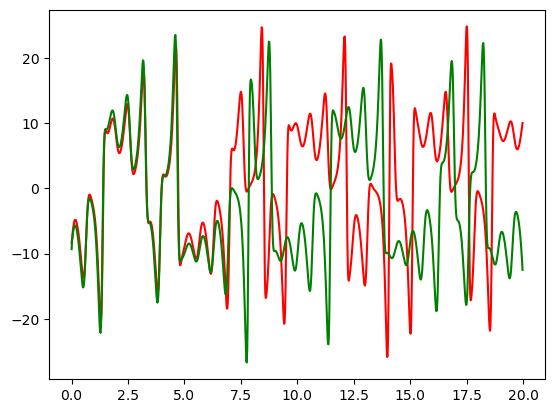

In [3]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.02
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
rpid = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = rpid
    

    xp = sigma * (y - x) #+ np.random.normal(0, 0.1)
    yp = x * (rho - z) - y #+ np.random.normal(0, 0.1) 
    zp = x * y - beta * z #+ np.random.normal(0, 0.1)

    x += dt * xp
    y += dt * yp
    z += dt * zp

    rpid = np.tanh(A.dot(rpid) + Win.dot(u) + 1)
    #f[:, t] = np.array([x, y, z])
    f[:, t] = u


## Using only last 10000 data points for training
#f = f[:, -10000:] 
#R = R[:, -10000:]


## Finding Wout matrix using ridge regression
Wout_pid = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n)))  

### Testing

## Initializing testing parameters
Ttest = 200
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)
disfac = 10
controlgain = 1.5

## For storing x, y, z time series data of ideal system
xpure = np.zeros(ntest)
ypure = np.zeros(ntest)
zpure = np.zeros(ntest)

## For storing x, y, z time series data of system with disturbance with no control
xnocontrol = np.zeros(ntest)
ynocontrol = np.zeros(ntest)
znocontrol = np.zeros(ntest)

## For storing x, y, z time series data of actual system
xpid = np.zeros(ntest + 1)             
ypid = np.zeros(ntest + 1)
zpid = np.zeros(ntest + 1)

## For storing error time series data
#err = np.zeros(ntest)

xxpure, yypure, zzpure = x, y, z
xxnocontrol, yynocontrol, zznocontrol = x, y, z
xxpid, yypid, zzpid = x, y, z
xpid[0], ypid[0], zpid[0] = x, y, z
xtrack, ytrack, ztrack = x, y, z

## Time evolution
for t in range(ntest):

    ## Ideal system

    xxpurep = sigma * (yypure - xxpure)
    yypurep = xxpure * (rho - zzpure) - yypure
    zzpurep = xxpure * yypure - beta * zzpure

    xxpure += dt * xxpurep
    yypure += dt * yypurep
    zzpure += dt * zzpurep

    xpure[t] = xxpure
    ypure[t] = yypure
    zpure[t] = zzpure   

    ## With disturbance (Real trajectory with no control)

    xxnocontrolp = sigma * (yynocontrol - xxnocontrol)
    yynocontrolp = xxnocontrol * (rho - zznocontrol) - yynocontrol + disfac * xxnocontrol
    zznocontrolp = xxnocontrol * yynocontrol - beta * zznocontrol
    
    xxnocontrol += dt * xxnocontrolp
    yynocontrol += dt * yynocontrolp
    zznocontrol += dt * zznocontrolp

    xnocontrol[t] = xxnocontrol
    ynocontrol[t] = yynocontrol
    znocontrol[t] = zznocontrol

    ## Actual system with PID control
   
    rpid = np.tanh(A.dot(rpid) + Win.dot(np.array([xtrack, ytrack, ztrack])) + np.ones(n))
    xtrack, ytrack, ztrack = Wout_pid.dot(rpid)

    xxpidp = sigma * (yypid - xxpid)
    yypidp = xxpid * (rho - zzpid) - yypid + disfac * xxpid
    zzpidp = xxpid * yypid - beta * zzpid
    
    xxpid += dt * xxpidp + controlgain * (xtrack - xxpid)
    yypid += dt * yypidp + controlgain * (ytrack - yypid)
    zzpid += dt * zzpidp + controlgain * (ztrack - zzpid)
    

    xpid[t] = xxpid
    ypid[t] = yypid
    zpid[t] = zzpid



plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D(xpure, ypure, zpure, 'r', linewidth = 0.1, label = 'True model')
ax.plot3D(xnocontrol, ynocontrol, znocontrol, 'b', linewidth = 0.1, label = 'Disturbance but no control')
ax.plot3D(xpid, ypid, zpid, 'g', linewidth = 0.1, label = 'Tracked model with no noise in derivative terms')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Finding distance between tracked and true model at each time instant and averaging it
#avgtimedist = np.mean(np.sqrt((xpure - xpid[:ntest])**2 + (ypure - ypid[:ntest])**2 + (zpure - zpid[:ntest])**2))

#print('Average of distances calculated at each instant:', avgtimedist)


## Finding distance between tracked and true model by finding the minimum distance between the two time series
#A = np.array([xpure[-5000:], ypure[-5000:], zpure[-5000:]])
#B = np.array([xpid[-5000:], ypid[-5000:], zpid[-5000:]])
#avgdist = np.mean(norm(A[:, :, None] - B[:, None, :], axis=0).min(axis=0))
#print('Average of minimum distances:', avgdist)

plt.figure()
plt.plot(testingtimes[:1000], xpure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], xpid[:1000],  'g', label = 'Tracked model')
plt.show()


plt.figure()
plt.plot(testingtimes[:1000], ypure[:1000], 'r', label = 'True model')
plt.plot(testingtimes[:1000], ypid[:1000],  'g', label = 'Tracked model')
plt.show()